# Análise do Dataset

In [1]:
import math
import numpy as np
import pandas as pd


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium

#import folium.colormap as cm
from geopy.distance import vincenty
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [26]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.io import show, output_file, export_png

In [27]:
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('default')
sns.set(style="whitegrid")

output_notebook()

Loading BokehJS ...

### Read Dataset

In [28]:
df = pd.read_csv('../input/clients_2017_11_17.csv')

Campos anteriores:

* **activity_id ** : identificador do ramo de atividade
* **post_code  ** : CEP do endereço
* **salesman_id_1 ** : id do vendedor 1
* **neighborhood ** : bairro
* **state  ** : estado
* **block ** : complemento do endereço
* **avg_ticket  ** : média das vendas (valor total das vendas de cada cliente / número de pedidos)
* **city  ** : cidade
* **city_id  ** : id da cidade no IBGE
* **last_order  ** : data da última compra do cliente
* **house_number  ** : número do endereço
* **geocode_score  ** : score da nossa geocodificação
* **revenue_avg   ** : média do faturamento mensal (levando em conta os últimos 20 meses ** : valor total das vendas de cada cliente / número de meses(20))
* **cod_uf  ** : código do estado segundo o IBGE
* **thoroughfare  ** : logradouro
* **blocked  ** : indica se o cliente está bloqueado no sistema. Esse cliente não deve ser visitado
* **client_id  ** : identificador único do cliente no sistema
* **avg_order_frequency  ** : média do número de vendas realizadas por mês (número total de pedidos / número de meses (20)) 
* **cod_tract  ** : id do setor censitário no IBGE
* **supervisor_id  ** : identificador do supervisor
* **activity ** : ramo de atividade da empresa
* **lat ** : latitude do ponto da empresa geocodificada
* **lon ** : longitude do ponto da empresa geocodificada
* **reference_point_lat ** : latitude do ponto de origem do vendedor
* **reference_point_lon  ** : longitude do ponto de origem do vendedor
* **visit_frequency  ** : frequencia de visitas (1 - semanal; 2 - quinzenal; 4 - mensal)
* **orders_day_of_week ** : lista de dias na semana em que o cliente é visitado (1 - domingo, 2 - segunda, ..., 7 - sábado)

Adicionados os seguintes campos:
* ** time_to_attend **  : tempo em minutos que o vendedor fica no cliente durante o atendimento
* **salesman_cost_reais **  : custo mensal do vendedor em reais
* **abc ** : Inidica se o cliente é A, B ou C na curva ABC. Os clientes "A" juntos representam 80% do faturamento. Os clientes "B" representam 15% do faturamento e os clientes "C" 5%

In [29]:
df.head()

,time_to_attend,abc,salesman_id_1,region_id,state,neighborhood_id,block,reference_point_lon,avg_ticket,visit_frequency,...,distributor_id,neighborhood,_geom_centroid,salesman_type,house_number,geocode_score,revenue_avg,route,thoroughfare,avg_order_frequency
0,29,B,710,604,GO,NaN,S/C,-47.332794,"276,03",1,...,1.0,BEZERRA,-47.334410,I,s/n,0.469042,"337,37",FORMOSA,ROD. BR-020,"1,00"
1,26,B,730,407,GO,NaN,S/C,-49.948030,"299,83",1,...,1.0,VILA SAO JOSE,-49.936802,I,S/N,0.650388,"299,83",ITAPURANGA,RUA SANTA CRUZ,"1,00"
2,24,C,517,457,GO,NaN,QD.44 LT.01,-48.944700,"40,83",1,...,1.0,LOURDES,-48.921938,I,S/N,1.000000,"40,83",ANAPOLIS,AV. ANGELICA,"1,00"
3,25,B,696,41,GO,NaN,QD.02 LT.01- A SALA.1,-51.108563,"324,21",1,...,1.0,BELA VISTA,-52.253200,I,1916,0.684866,"498,78",ARAGARCAS,AV. MINISTRO JOAO ALBERTO,"1,00"
4,48,A,574,351,GO,NaN,"QD.28 LT.02, 03 N.296, 297, 309 E 310",-48.957236,"1230,98",2,...,1.0,JARDIM DAS OLIVEIRAS I,-49.156566,E,284,0.998970,"3174,63",SENADOR CANEDO,AV. DAS MACAUBAS,"2,00"


In [30]:
df['revenue_avg'] = [x.replace(',', '.') for x in df['revenue_avg']]
df['revenue_avg'] = df['revenue_avg'].astype(float)

In [31]:
df.sort_values(by=['revenue_avg'], ascending=False).iloc[0]

time_to_attend                               15
abc                                           A
salesman_id_1                               670
region_id                                   363
state                                        GO
neighborhood_id                             NaN
block                              QD.133 LT.01
reference_point_lon                    -49.3281
avg_ticket                             57014,03
visit_frequency                               4
city                                    GOIANIA
city_id                                   16484
last_order             2017-08-28T00:00:00.000Z
salesman_cost_reais                        2997
route_id                                    100
cod_uf                                       52
orders_day_of_week                 [2, 3, 4, 5]
blocked                                   False
client_id                                 22018
lat                                    -16.6761
cod_tract                       52087070

In [41]:
#activity = 'PE - FARMACIAS E DROGARIAS'
#df = df[df.activity == activity]
df = df[np.isin(df.salesman_id_1, [93, 430, 694, 517, 721, 517, 370, 578, 635, 578, 483, 665, 731,
       578, 694, 694, 578, 731, 430, 721, 688, 721, 721, 665, 560, 711,
       712, 483, 475, 640, 517, 712, 635, 610, 694, 720, 640, 639, 742,
       644, 721, 647, 721, 578, 694, 475, 430, 560, 560, 578, 475, 483,
       610, 665, 640, 427, 517, 578, 694, 721, 665, 574, 578, 640, 721,
       721, 517, 560, 730, 635, 731, 578, 517, 430, 721, 603, 603, 696,
       710, 635, 578, 483, 610, 731, 610, 475, 696, 635])]

In [43]:
df.activity
#df.salesman_id_1.values

0                              PE - CHURRASCARIA
1                                 PE - MERCEARIA
2                                    PE - OUTROS
3                         PE - LOJA CONVENIENCIA
4                    PE - AS - MAIS 9 CHECK OUTS
5                        PE - AS - 03 CHECK OUTS
6                                    PE - OUTROS
7                            PE - PADARIA BASICA
11                              PE - RESTAURANTE
12                       PE - AS - 04 CHECK OUTS
13                           PE - PADARIA BASICA
14                          PE - PADARIA PREMIUM
15                    PE - FARMACIAS E DROGARIAS
16                        PE - LOJA CONVENIENCIA
18                          PE - PADARIA REGULAR
20                                   PE - OUTROS
21                      PE - ATACADO MEDIO PORTE
22                                   PE - OUTROS
23                          PE - PADARIA REGULAR
24                              PE - LANCHONETES
25                  

In [44]:
# Geographical centre of search (Goiania)
c_latitude = -16.673960
c_longitude = -49.270990

linearColor = folium.LinearColormap(['green', 'yellow', 'red'],
                           vmin=df.salesman_id_1.min(), vmax=df.salesman_id_1.max())

## Clientes

In [45]:
df_clients = df[['client_id', 'salesman_id_1', 'lat', 
    'lon', 'revenue_avg']].drop_duplicates()
df_clients.set_index('client_id')

len(df_clients)

2829

In [46]:
df_clients.sort_values(by=['revenue_avg'], ascending=False).head(10)

,client_id,salesman_id_1,lat,lon,revenue_avg
492,605,370,-16.801507,-49.267770,29679.60
3490,8657,578,-16.188625,-48.684213,17039.34
1447,10928,93,-16.057356,-48.025947,9794.26
2407,3673,574,-16.350011,-48.958113,6816.26
2848,1114,427,-16.713696,-49.273982,6500.65
164,17935,560,-16.253997,-47.899616,6377.03
2666,6932,93,-16.057684,-48.011707,5893.48
2046,4447,574,-16.344241,-48.946117,5836.46
1023,19958,93,-16.256848,-47.957515,5388.72
973,7396,574,-16.321265,-48.957075,5298.41


In [47]:
# Build map 
map_nyc = folium.Map(location=[c_latitude, c_longitude], zoom_start=11, width=840, height=580, 
                    tiles='cartodbpositron')
# Plot coordinates using comprehension list
for index, row in df_clients.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], 
                        popup="{}: {}".format(index, row.revenue_avg),
                        radius=10,
                        color=linearColor(row.salesman_id_1), 
                        fill_color=linearColor(row.salesman_id_1)).add_to(map_nyc) 
map_nyc

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/marlesson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


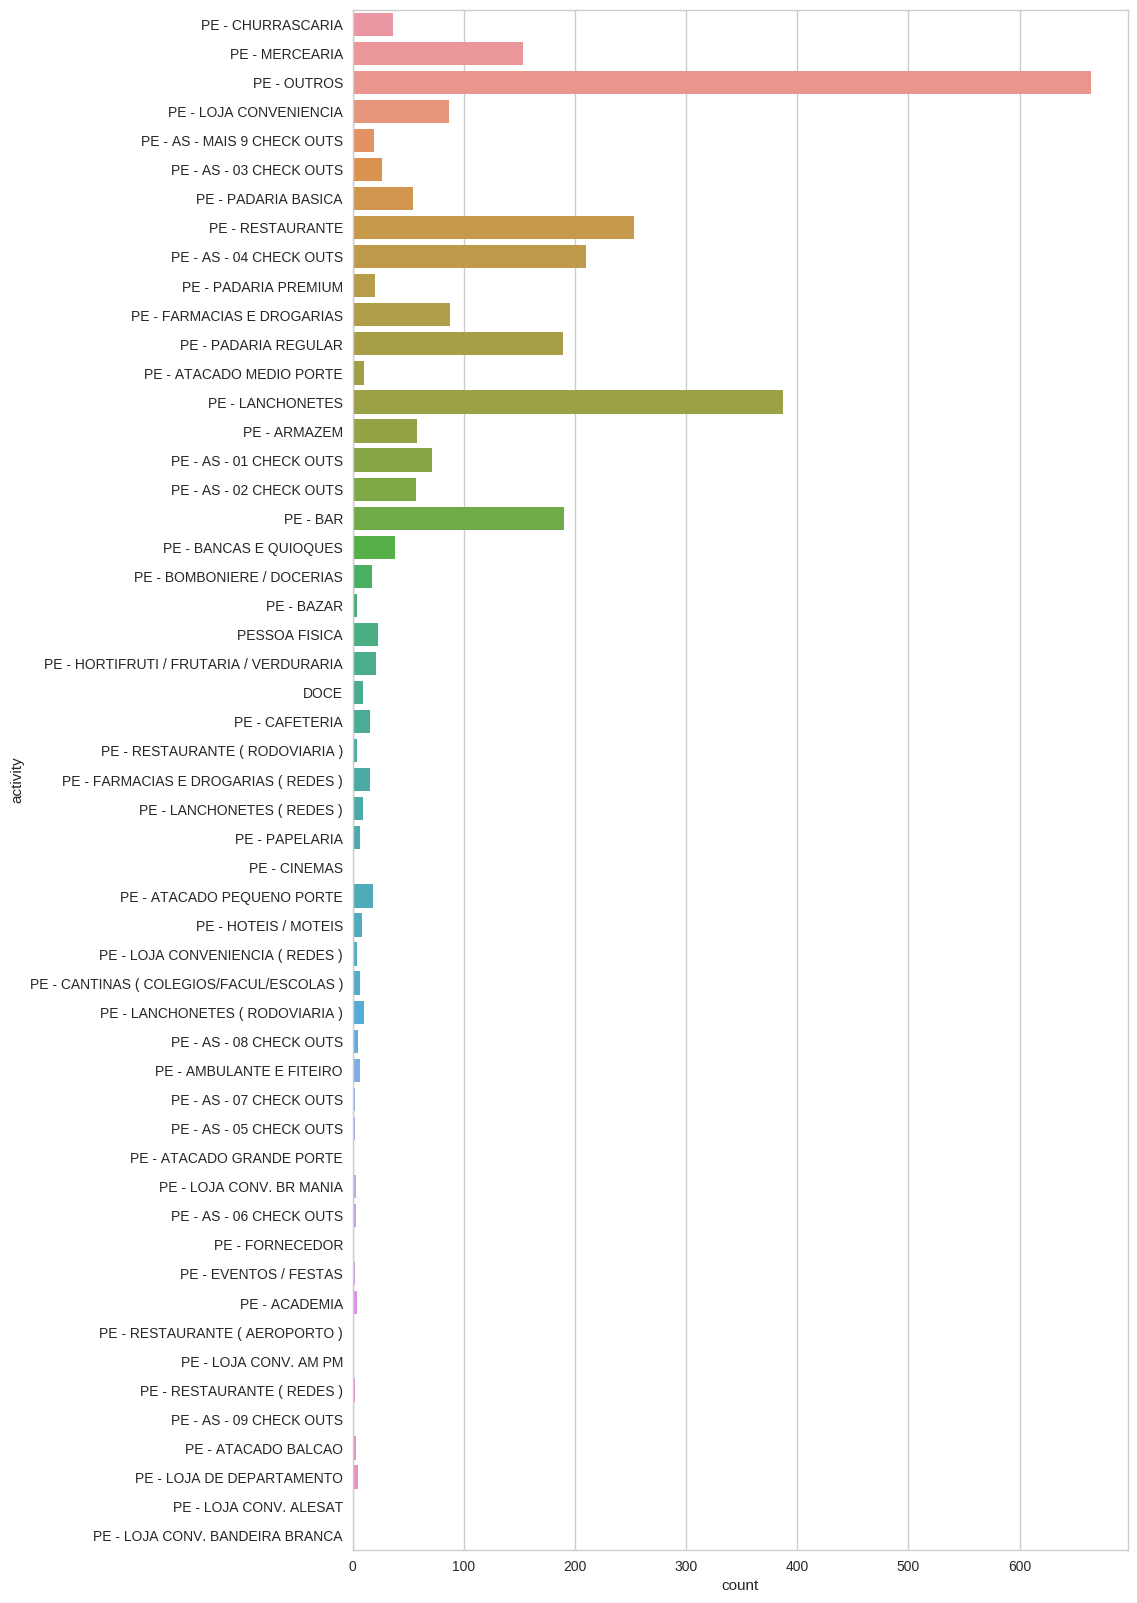

In [48]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 20))

sns.countplot(y="activity", data=df)

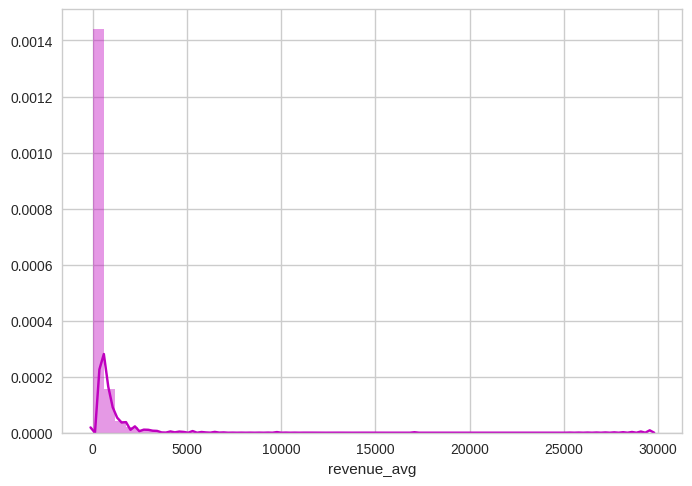

In [49]:
sns.distplot(df.revenue_avg, color="m")

In [50]:
sorted(df.revenue_avg)[-5:-1]

[6500.65, 6816.26, 9794.26, 17039.34]

/home/marlesson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1843: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1844: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


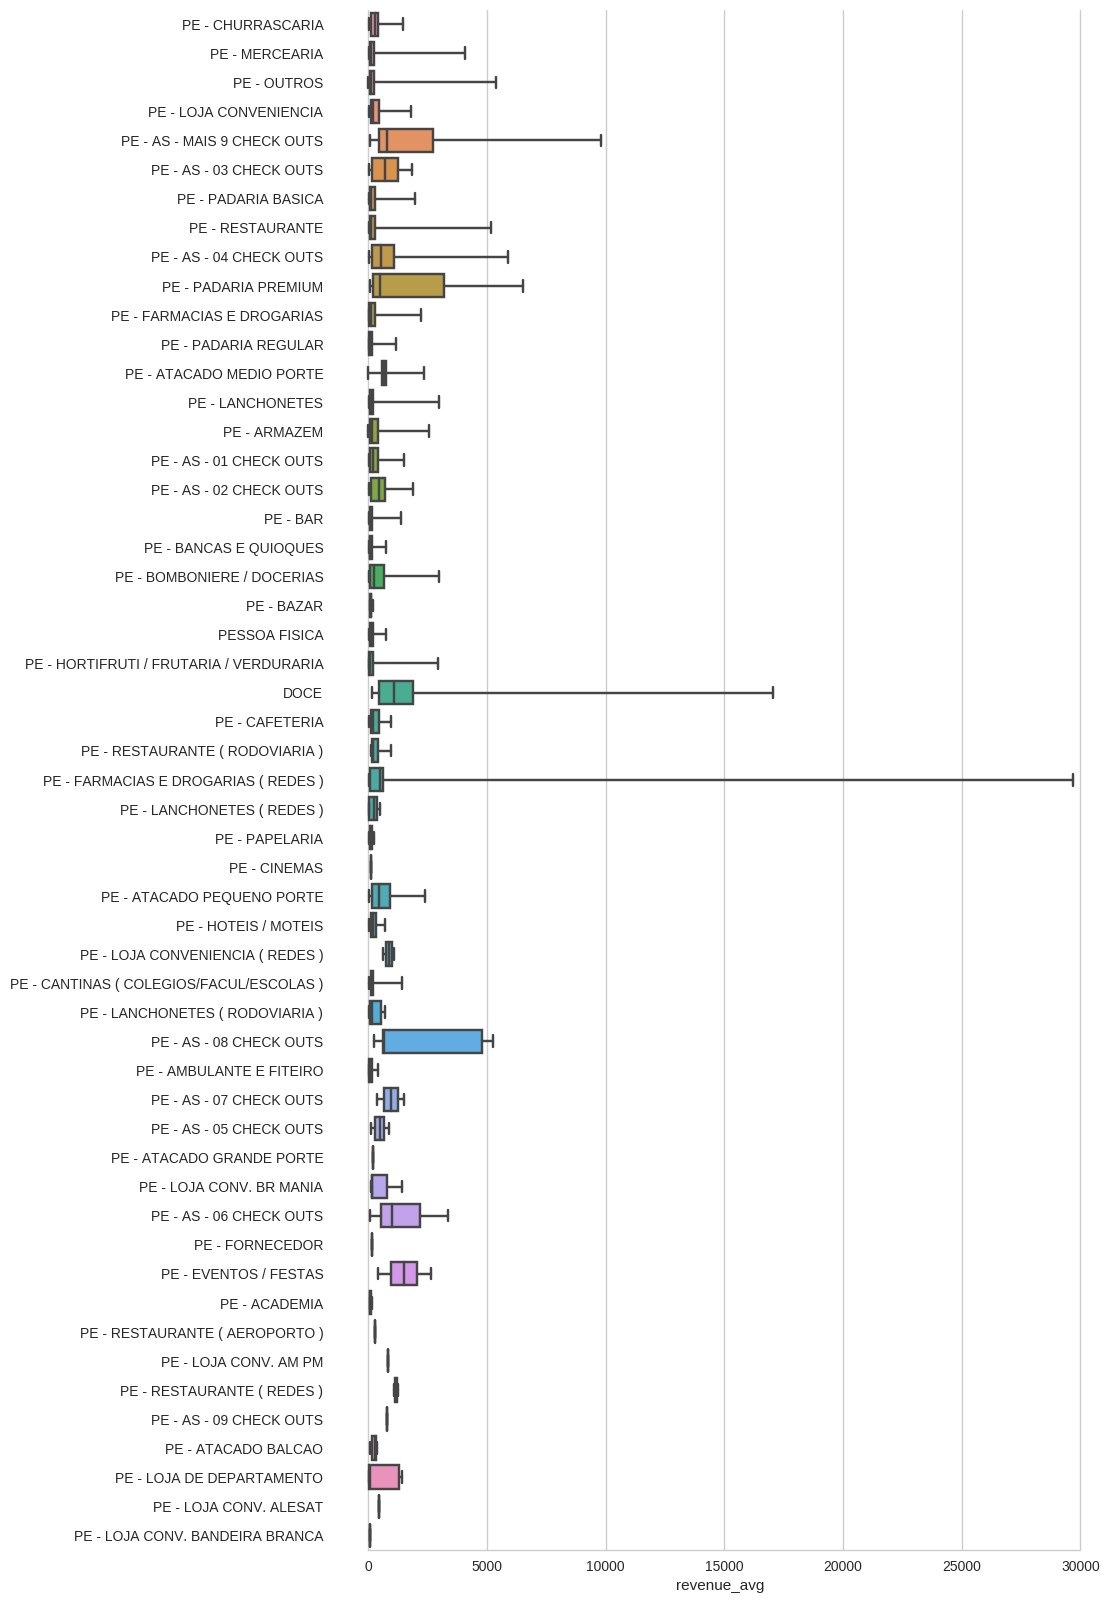

In [51]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 20))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="revenue_avg", y="activity", data=df,
            whis=np.inf)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

## Representantes

In [16]:
df_group = df.groupby(['salesman_id_1'])['salesman_id_1', 'revenue_avg'].mean()
df_group.head()

,salesman_id_1,revenue_avg
salesman_id_1,,
52,52,42883.980000
93,93,1989.579000
146,146,6808.358824
285,285,186.576000
330,330,5622.205000


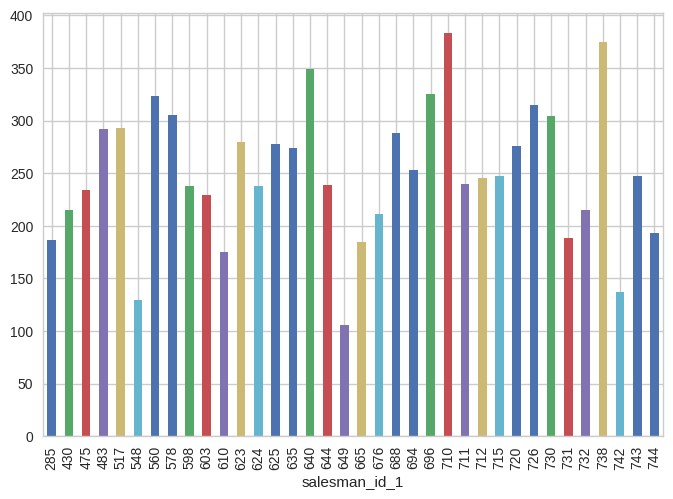

In [24]:
limit = df_group.revenue_avg.mean()
df_salesman = df_group[df_group.revenue_avg < 500]
df_salesman.revenue_avg.plot(kind='bar')

In [16]:
df_salesman = df[['salesman_id_1', 'reference_point_lon', 
    'reference_point_lat', 'salesman_cost_reais']].drop_duplicates()
df_salesman.set_index('salesman_id_1')

len(df_salesman)

66

/home/marlesson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1843: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1844: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1857: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1864: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


KeyboardInterrupt: 

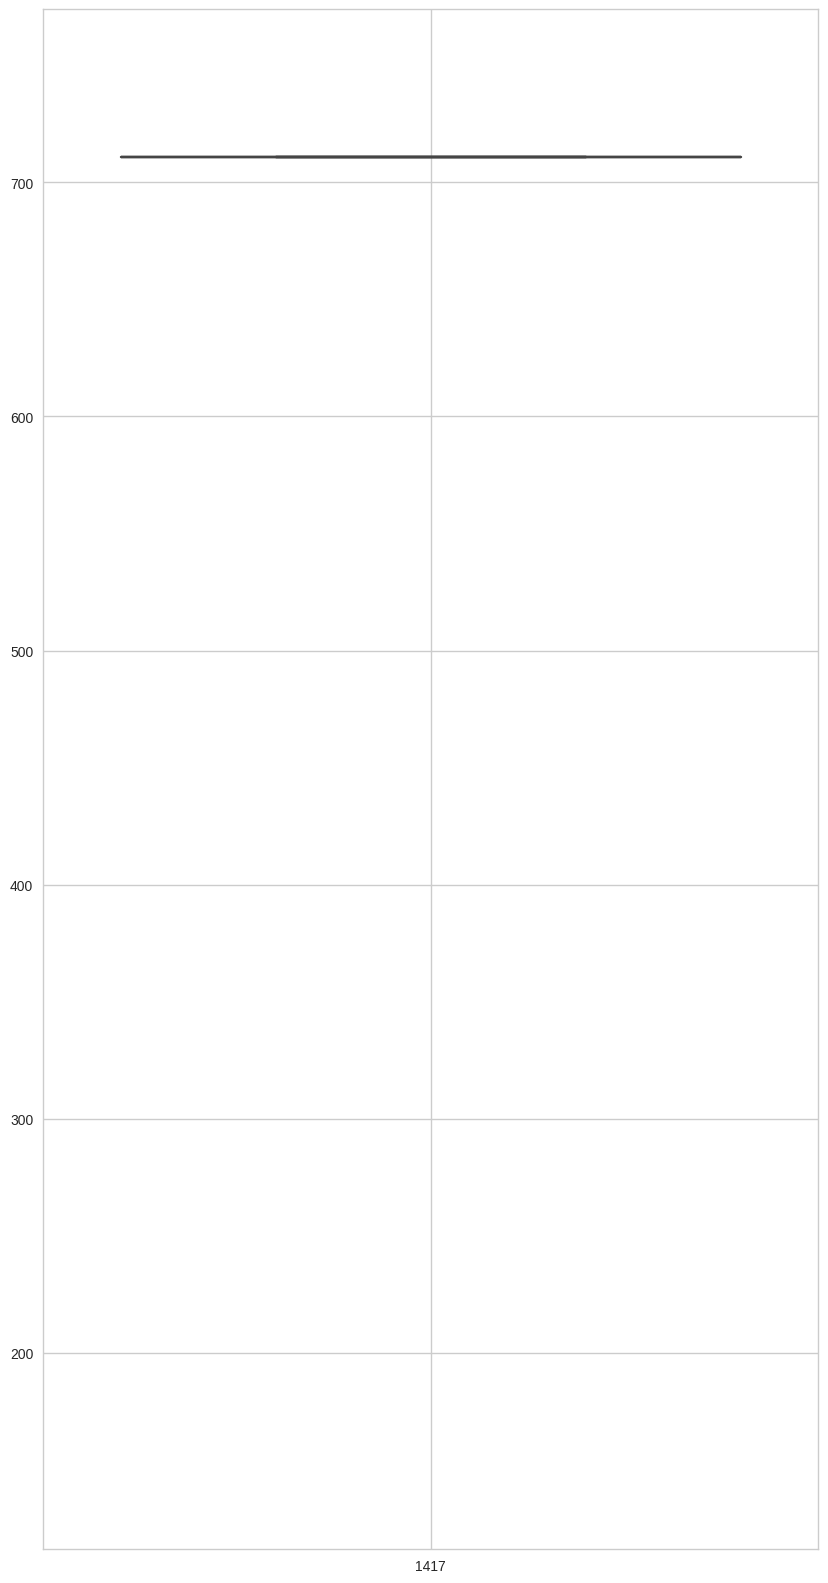

In [19]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 20))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="revenue_avg", y="salesman_id_1", data=df,
            whis=np.inf)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [17]:
# Build map 
map_nyc = folium.Map(location=[c_latitude, c_longitude], zoom_start=11, width=840, height=580, 
                    tiles='cartodbpositron')
# Plot coordinates using comprehension list
for index, row in df_salesman.iterrows():
    folium.CircleMarker(location=[row.reference_point_lat, row.reference_point_lon], 
                        popup="{}: {}".format(index, row.salesman_cost_reais),
                        radius=10,
                        color=linearColor(row.salesman_id_1), 
                        fill_color=linearColor(row.salesman_id_1)).add_to(map_nyc) 
map_nyc

/home/marlesson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


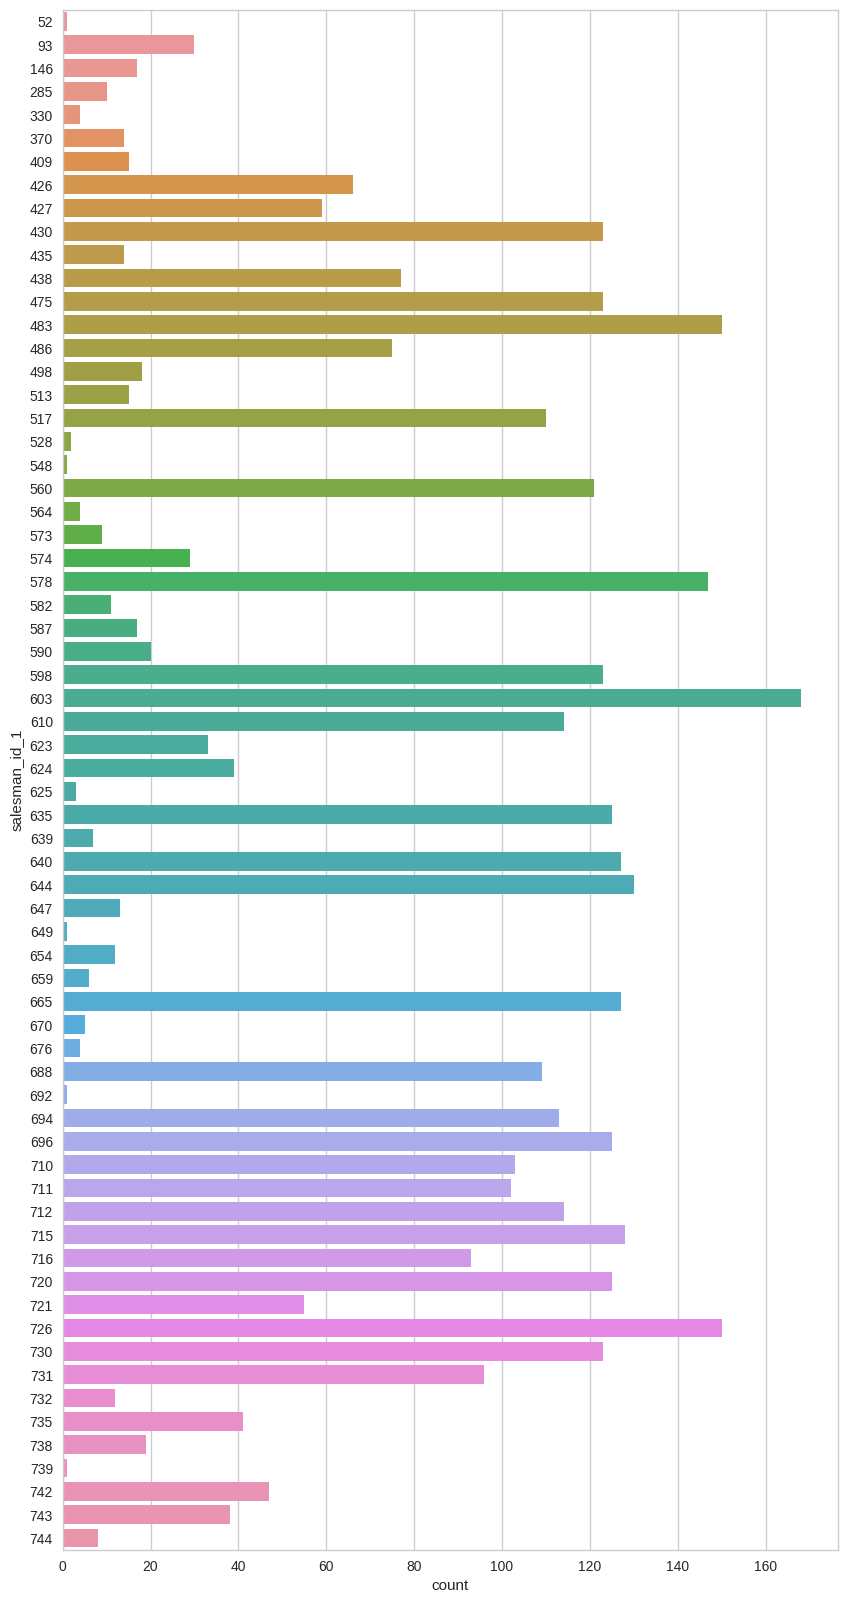

In [18]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 20))

sns.countplot(y="salesman_id_1", data=df)

/home/marlesson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


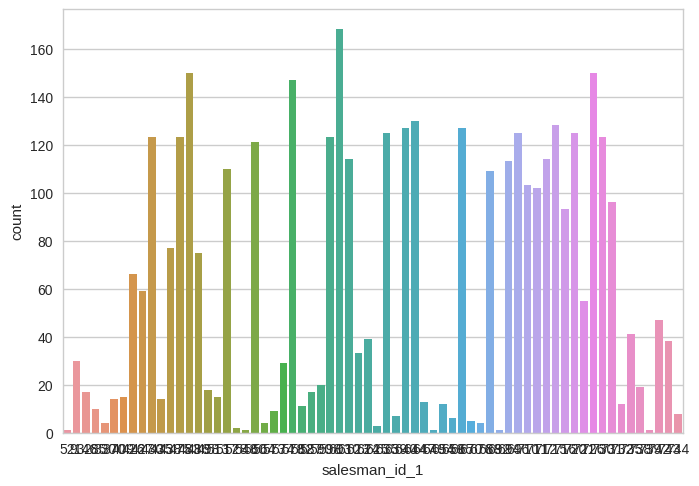

In [19]:
sns.countplot(x="salesman_id_1", data=df)

### Carteira de Clientes

In [23]:
df_720 = df[df['salesman_id_1'] == 720]
len(df_720)

125

In [27]:
df_720.revenue_avg.sum()

34429.049999999988

In [29]:
df_720.salesman_cost_reais.max()

3914.75

In [31]:
df_input = df[['client_id', 'lat', 'lon', 'revenue_avg', 'salesman_id_1', 
               'reference_point_lon', 'reference_point_lat', 
               'salesman_cost_reais']]

In [33]:
df_input.to_csv('input/input_data.csv')

In [71]:
df = pd.read_csv('input/priority.csv')
df.head()

,client_id,salesman_id,priority
0,21007,710,0.0
1,9695,730,0.5


In [72]:
#df['client_id_salesman_id'] = df.client_id + df.salesman_id

df = df.set_index(['client_id', 'salesman_id'])
df.head()

,,priority
client_id,salesman_id,
21007,710,0.0
9695,730,0.5


In [73]:
df.iloc[df.index.get_loc((21007,710))].priority

0.0

In [74]:
df.iloc[df.index.get_loc((21007,7102))].priority

KeyError: (21007, 7102)

### Prioridade

In [87]:
# Matrix
m = np.zeros((len(salesman_index), len(clients_index)))

# Read dataset
if file != None:
  df = pd.read_csv(file)
  df = df.set_index(['client_id', 'salesman_id'])

# Rep
for s in range(len(salesman_index)):
    # Cli
    for t in range(len(clients_index)):

        try:
          pry = df.iloc[df.index.get_loc((int(clients_index[t]), int(salesman_index[s])))].priority
        except: 
          pry = default_priority

        m[s, t] = pry

return m   

NameError: name 'salesman_index' is not defined

In [121]:
df_pri = df[['client_id', 'salesman_id_1', 'abc']]
df_pri = df_pri.set_index(['client_id', 'salesman_id_1'])
df_pri.head(5)

,,abc
client_id,salesman_id_1,
21007,710,B
9695,730,B
12995,517,C
8384,696,B
7458,574,A


In [152]:
df_pri.iloc[df_pri.index.get_loc((9695, 696))].abc

KeyError: (9695, 696)

In [133]:
len(np.unique(df[df['abc'] == 'B'].client_id))

1306

In [160]:
data_pry = []

In [161]:
for salesman in np.unique(df.salesman_id_1):
    for client in np.unique(df[df['abc'] == 'C'].client_id):
        try:
            abc = df_pri.iloc[df_pri.index.get_loc((client, salesman))].abc
            pry = 0.1
        except: 
            pry = 1
        data_pry.append([client, salesman, pry])

In [162]:
for salesman in np.unique(df.salesman_id_1):
    for client in np.unique(df[df['abc'] == 'B'].client_id):
        try:
            abc = df_pri.iloc[df_pri.index.get_loc((client, salesman))].abc
            pry = 1
        except: 
            pry = 0.1
        data_pry.append([client, salesman, pry])

In [163]:
for salesman in np.unique(df.salesman_id_1):
    for client in np.unique(df[df['abc'] == 'A'].client_id):
        try:
            abc = df_pri.iloc[df_pri.index.get_loc((client, salesman))].abc
            pry = 1
        except: 
            pry = 0.1
        data_pry.append([client, salesman, pry])

In [164]:
df_value_pry = pd.DataFrame(data_pry, columns = ['client_id', 'salesman_id', 'priority'])

In [165]:
df_value_pry.to_csv('input/priority.csv')